In [ ]:
!pip install -q mnists equinox

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
import optax
from jaxtyping import Array, Float, Int, PyTree
import jax.tree_util as jtu

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import mnists
import numpy as np
from sklearn.model_selection import train_test_split

dataset = mnists.MNIST()

X_train = dataset.train_images().astype(np.float32)[:, None, :] / 255.0
y_train = dataset.train_labels().astype(np.int32)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=0,
)

X_test = dataset.test_images().astype(np.float32)[:, None, :] / 255.0
y_test = dataset.test_labels().astype(np.int32)

BATCH_SIZE = 512

In [3]:
def batch_data(*args, batch_size, enum=False, shorten=False):
    assert shorten or all(len(x) == len(args[0]) for x in args)
    n = min(len(x) for x in args)
    for i in range(0, n, batch_size):
        if enum:
            yield (i, *(x[i:i+batch_size] for x in args))
        else:
            yield (x[i:i+batch_size] for x in args)

_i, X_dummy, y_dummy = next(iter(batch_data(X_train, y_train, enum=True, batch_size=BATCH_SIZE)))
X_dummy.shape, y_dummy.shape, type(X_dummy), _i

((512, 1, 28, 28), (512,), numpy.ndarray, 0)

In [4]:
def tiles(examples, title=""):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]

    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = examples[r, c]

    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.title(title)

(54000, 1, 28, 28)


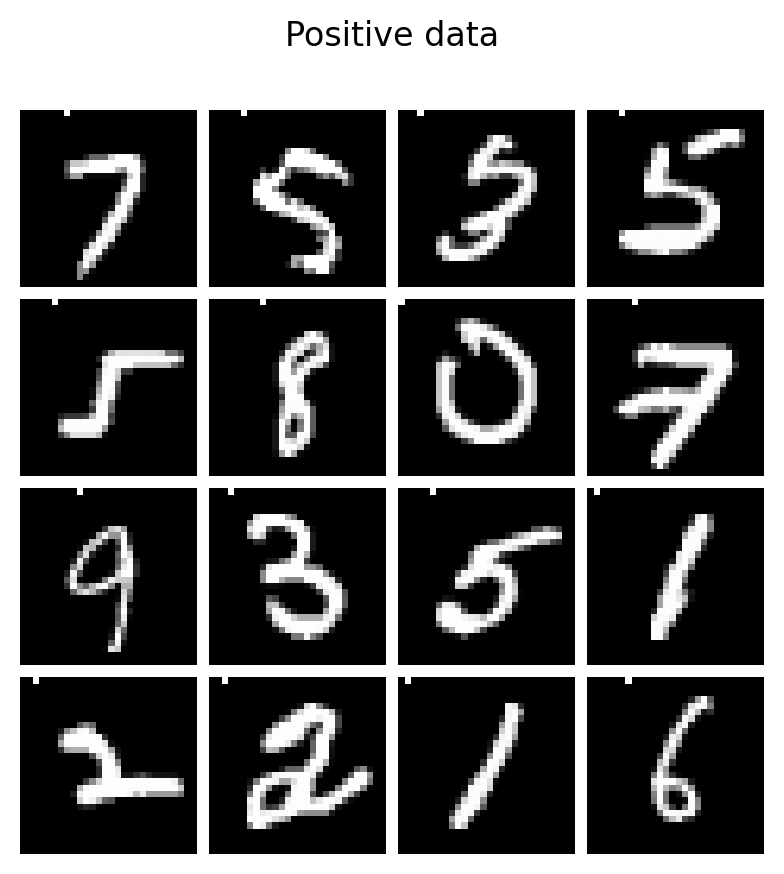

In [5]:
def jnp_encode_class_in_image(X, y, num_classes):
    y = jnp.eye(num_classes)[y]
    orig_shape = X.shape
    X = X.reshape(X.shape[0], -1)
    X = X.at[:, :num_classes].set(y)
    X = X.reshape(orig_shape)
    return X

def np_encode_class_in_image(X, y, num_classes):
    y = np.eye(num_classes)[y]
    orig_shape = X.shape
    X = X.copy()
    X = X.reshape(X.shape[0], -1)
    X[:, :num_classes] = y
    X = X.reshape(orig_shape)
    return X

X_train_pos = np_encode_class_in_image(X_train, y_train, len(dataset.classes))

print(X_train_pos.shape)
tiles(X_train_pos[:16].reshape(4, 4, 28, 28), "Positive data")

(54000, 1, 28, 28)


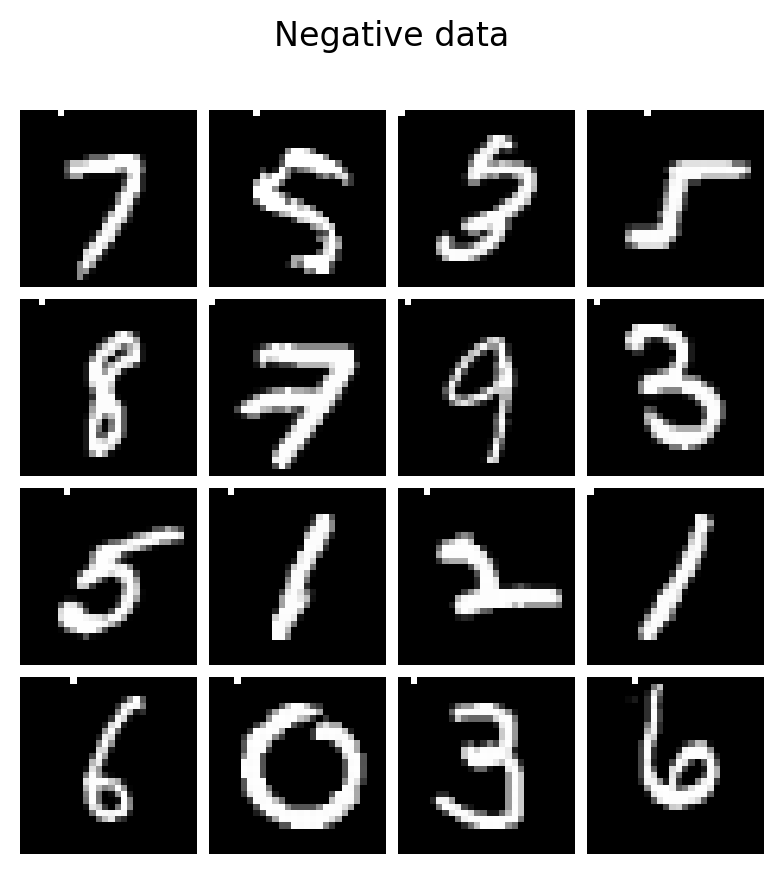

In [6]:
def derange(y, rng, max_iters):
    best_permuted_y = y
    best_n_deranged = 0
    for _ in range(max_iters):
        permuted_y = rng.permutation(y)
        n_deranged = (permuted_y != y).sum()
        if n_deranged > best_n_deranged:
            best_permuted_y = permuted_y
            best_n_deranged = n_deranged
    return permuted_y

y_train_concat = np.concatenate([y_train, y_train])
y_train_neg = derange(y_train_concat, np.random.default_rng(0), 10)  # more iters are not worth it

# remove positive labels and adjust size
neg_idxs = y_train_neg != y_train_concat  
X_train_neg = np.concatenate([X_train, X_train])[neg_idxs]
X_train_neg = X_train_neg[:len(X_train)]
y_train_neg = y_train_neg[neg_idxs]
y_train_neg = y_train_neg[:len(y_train)]
X_train_neg = np_encode_class_in_image(X_train_neg, y_train_neg, len(dataset.classes))
del y_train_neg

print(X_train_neg.shape)
tiles(X_train_neg[:16].reshape(4, 4, 28, 28), "Negative data")

In [7]:
NORMALIZATION_OFFSET = 1e-4

def normalize(x):
    return x / (jnp.linalg.norm(x) + NORMALIZATION_OFFSET)

In [160]:
from functools import partial

class FFLayer(eqx.Module):
    layers: list

    def __init__(self, *layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class FFNetwork(eqx.Module):
    layers: list

    def __init__(self, key):
        keys = jax.random.split(key, 5)
        self.layers = [
            FFLayer(
                normalize,
                jnp.ravel,
                eqx.nn.Linear(784, 512, key=keys[2]),
                jax.nn.relu,
            ),
            FFLayer(
                normalize,
                eqx.nn.Linear(512, 512, key=keys[3]),
                jax.nn.relu,
            ),
            FFLayer(
                normalize,
                eqx.nn.Linear(512, 10, key=keys[3]),
                jax.nn.relu,
            ),
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "500"]:
        for layer in self.layers:
            x = layer(x)
        return x

model = FFNetwork(jax.random.PRNGKey(0))
print(model(X_dummy[0]).shape)
print(eqx.filter_vmap(model)(X_dummy).shape)

(10,)
(512, 10)


In [161]:
def goodness_fn(x: Float[Array, "batch ..."]) -> Float[Array, "batch"]:
    return (x * x).reshape(x.shape[0], -1).mean(axis=-1)

In [162]:
@eqx.filter_jit
def loss_and_outputs(
    layer: FFLayer,
    x: Float[Array, "batch ..."],
    sgn: float,
    threshold: float,
) -> tuple[Float[Array, ""], Float[Array, "batch ..."]]:
    x = jax.vmap(layer)(x)
    g = sgn * (goodness_fn(x) - threshold)
    # g = jax.nn.sigmoid(g).mean()
    g = jax.nn.softplus(g).mean()
    return g, x

print(loss_and_outputs(model.layers[0], X_dummy, sgn=1, threshold=2)[0])
loss_and_outputs(model.layers[0], X_dummy, sgn=-1, threshold=2)[0]

0.12697868


Array(2.1265538, dtype=float32)

In [163]:
x = X_dummy

for layer in model.layers:
    loss_val, x = loss_and_outputs(layer, x, sgn=-1, threshold=2)
    print(loss_val, x.shape)

2.1265538 (512, 512)
2.1262922 (512, 512)
2.1252146 (512, 10)


In [164]:
print(list(map(type, 
    eqx.filter_grad(loss_and_outputs, has_aux=True)(
        model.layers[0], X_dummy, sgn=-1, threshold=5
    )
)))
print(list(map(type,
    eqx.filter_value_and_grad(loss_and_outputs, has_aux=True)(
        model.layers[0], X_dummy, sgn=-1, threshold=2
    )
)))

[<class '__main__.FFLayer'>, <class 'jaxlib.xla_extension.ArrayImpl'>]
[<class 'tuple'>, <class '__main__.FFLayer'>]


In [165]:
NUM_CLASSES = 10

In [166]:
@eqx.filter_jit
def predict(
    model: FFNetwork,
    x: Float[Array, "batch 1 28 28"],
    num_classes: int = NUM_CLASSES,
) -> Float[Array, "batch num_classes"]:
    preds = jnp.zeros((x.shape[0], num_classes))
    layers = list(map(eqx.filter_vmap, model.layers))

    for label in jnp.arange(num_classes):
        t = jnp_encode_class_in_image(x, label, num_classes)
        t = layers[0](t)

        goodness = 0
        for layer in layers[1:]:
            t = layer(t)
            goodness += goodness_fn(t)
        preds = preds.at[:, label].set(goodness)

    return preds

predict(model, X_dummy).shape

(512, 10)

In [167]:
def batch_predict(model, X, batch_size, num_classes=NUM_CLASSES):
    preds = jnp.zeros((X.shape[0], num_classes))

    for i, x in batch_data(X, batch_size=batch_size, enum=True):
        batch_preds = predict(model, x, num_classes)
        preds = preds.at[i:i+batch_size].set(batch_preds)

    return preds

batch_predict(model, X_valid, BATCH_SIZE).shape

(6000, 10)

In [168]:
def compute_accuracy(model, x, y, num_classes=NUM_CLASSES):
    preds = predict(model, x, num_classes)
    pred_y = jax.nn.softmax(preds, axis=-1).argmax(axis=-1)
    return jnp.mean(y == pred_y)

compute_accuracy(model, X_dummy, y_dummy)

Array(0.1015625, dtype=float32)

In [169]:
def evaluate(model, X_test, y_test, batch_size, num_classes=NUM_CLASSES):
    avg_accuracy = 0
    avg_goodness = 0
    n_batches = (len(X_test) + batch_size - 1) // batch_size

    for x, y in batch_data(X_test, y_test, batch_size=batch_size):
        preds = predict(model, x, num_classes)
        pred_y = jax.nn.softmax(preds, axis=-1).argmax(axis=-1)
        goodness = preds[jnp.arange(preds.shape[0]), pred_y]
        avg_goodness += goodness.mean()
        avg_accuracy += jnp.mean(y == pred_y)

    avg_goodness /= n_batches
    avg_accuracy /= n_batches
    return avg_goodness, avg_accuracy

evaluate(model, X_test, y_test, batch_size=BATCH_SIZE)

(Array(0.00273464, dtype=float32), Array(0.0756721, dtype=float32))

In [170]:
from copy import deepcopy

def train(
    model: FFNetwork,
    optims: list[optax.GradientTransformation],
    opt_states,
    *,
    threshold: float,
    batch_size: int,
    epochs: int,
    print_every: int, 
    metrics,
):
    n_batches = (len(X_train) + batch_size - 1) // batch_size
    metrics = deepcopy(metrics)

    @eqx.filter_jit
    def make_substep(layer, opt_state, optim, x, sgn):
        grads, x = eqx.filter_grad(loss_and_outputs, has_aux=True)(
            layer, x, sgn=sgn, threshold=threshold
        )
        updates, opt_state = optim.update(grads, opt_state, layer)
        layer = eqx.apply_updates(layer, updates)

        return layer, opt_state, x

    def make_step(model, opt_states, x_pos, x_neg):
        pos_goodness = neg_goodness = 0
        
        for i, (layer, opt_state, optim) in enumerate(zip(model.layers, opt_states, optims)):
            layer, opt_state, x_pos = make_substep(layer, opt_state, optim, x_pos, sgn=-1.)
            layer, opt_state, x_neg = make_substep(layer, opt_state, optim, x_neg, sgn=1.)

            model = eqx.tree_at(lambda m: m.layers[i], model, layer)
            opt_states = eqx.tree_at(lambda o: o[i], opt_states, opt_state)

            pos_goodness += goodness_fn(x_pos).mean()
            neg_goodness += goodness_fn(x_neg).mean()

        return model, opt_states, pos_goodness, neg_goodness


    try:
        for epoch in range(epochs):
            avg_pos_goodness = avg_neg_goodness = 0

            for x_pos, x_neg in batch_data(
                X_train_pos, X_train_neg, 
                shorten=True, batch_size=batch_size
            ):
                model, opt_states, pos_goodness, neg_goodness = make_step(
                    model, opt_states, x_pos, x_neg
                )

                avg_pos_goodness += pos_goodness
                avg_neg_goodness += neg_goodness

            avg_pos_goodness = avg_pos_goodness.item() / n_batches
            avg_neg_goodness = avg_neg_goodness.item() / n_batches
            metrics["pos_goodness"].append(avg_pos_goodness)
            metrics["neg_goodness"].append(avg_neg_goodness)

            if (epoch + 1) % print_every == 0:
                valid_goodness, valid_accuracy = evaluate(model, X_valid, y_valid, batch_size)
                metrics["valid_goodness"].append(valid_goodness.item())
                metrics["valid_accuracy"].append(valid_accuracy.item())
                print(
                    f"[{epoch + 1:3d}] train_pos_goodness={avg_pos_goodness:10.3f} "
                    f"train_neg_goodness={avg_neg_goodness:10.3f} "
                    f"valid_goodness={valid_goodness:10.3f} "
                    f"valid_accuracy={valid_accuracy:8.5f} "
                )
    except KeyboardInterrupt:
        pass

    return model, opt_states, metrics

In [ ]:
def train_greedy(
    model: FFNetwork,
    optims: list[optax.GradientTransformation],
    opt_states,
    *,
    threshold: float,
    batch_size: int,
    epochs: int,
    print_every: int, 
    metrics,
):
    n_batches = (len(X_train) + batch_size - 1) // batch_size
    metrics = deepcopy(metrics)

    @eqx.filter_jit
    def make_step(layer, opt_state, optim, x, sgn):
        grads, x = eqx.filter_grad(loss_and_outputs, has_aux=True)(
            layer, x, sgn=sgn, threshold=threshold
        )
        updates, opt_state = optim.update(grads, opt_state, layer)
        layer = eqx.apply_updates(layer, updates)

        return layer, opt_state, x

    def make_step(model, opt_states, x_pos, x_neg):
        pos_goodness = neg_goodness = 0
        
        for i, (layer, opt_state, optim) in enumerate(zip(model.layers, opt_states, optims)):
            layer, opt_state, x_pos = make_substep(layer, opt_state, optim, x_pos, sgn=-1.)
            layer, opt_state, x_neg = make_substep(layer, opt_state, optim, x_neg, sgn=1.)

            model = eqx.tree_at(lambda m: m.layers[i], model, layer)
            opt_states = eqx.tree_at(lambda o: o[i], opt_states, opt_state)

            pos_goodness += goodness_fn(x_pos).mean()
            neg_goodness += goodness_fn(x_neg).mean()

        return model, opt_states, pos_goodness, neg_goodness


    try:
        for i, (layer, opt_state, optim) in enumerate(zip(model.layers, opt_states, optims)):
            
        for epoch in range(epochs):
            avg_pos_goodness = avg_neg_goodness = 0

            for x_pos, x_neg in batch_data(
                X_train_pos, X_train_neg, 
                shorten=True, batch_size=batch_size
            ):
                model, opt_states, pos_goodness, neg_goodness = make_step(
                    model, opt_states, x_pos, x_neg
                )

                avg_pos_goodness += pos_goodness
                avg_neg_goodness += neg_goodness

            avg_pos_goodness = avg_pos_goodness.item() / n_batches
            avg_neg_goodness = avg_neg_goodness.item() / n_batches
            metrics["pos_goodness"].append(avg_pos_goodness)
            metrics["neg_goodness"].append(avg_neg_goodness)

            if (epoch + 1) % print_every == 0:
                valid_goodness, valid_accuracy = evaluate(model, X_valid, y_valid, batch_size)
                metrics["valid_goodness"].append(valid_goodness.item())
                metrics["valid_accuracy"].append(valid_accuracy.item())
                print(
                    f"[{epoch + 1:3d}] train_pos_goodness={avg_pos_goodness:10.3f} "
                    f"train_neg_goodness={avg_neg_goodness:10.3f} "
                    f"valid_goodness={valid_goodness:10.3f} "
                    f"valid_accuracy={valid_accuracy:8.5f} "
                )
    except KeyboardInterrupt:
        pass

    return model, opt_states, metrics

In [171]:
THRESHOLD = 10.
BATCH_SIZE = 512
LEARNING_RATE = 0.03
EPOCHS = 1000
PRINT_EVERY = 1

In [178]:
metrics = {
    "pos_goodness": [],
    "neg_goodness": [],
    "valid_goodness": [],
    "valid_accuracy": [],
}

optims = [optax.adamw(LEARNING_RATE) for _ in range(len(model.layers))]
opt_states = [optim.init(eqx.filter(layer, eqx.is_array))
              for optim, layer in zip(optims, model.layers)]

trained_model, trained_opt_states, metrics = train(
    model, optims, opt_states, metrics=metrics, 
    threshold=THRESHOLD, batch_size=BATCH_SIZE,
    epochs=EPOCHS, print_every=PRINT_EVERY
)

[  1] train_pos_goodness=    28.559 train_neg_goodness=    29.235 valid_goodness=    19.775 valid_accuracy= 0.01835 
[  2] train_pos_goodness=    29.534 train_neg_goodness=    30.043 valid_goodness=    19.790 valid_accuracy= 0.02765 
[  3] train_pos_goodness=    29.589 train_neg_goodness=    30.084 valid_goodness=    19.829 valid_accuracy= 0.02758 
[  4] train_pos_goodness=    29.632 train_neg_goodness=    30.106 valid_goodness=    19.885 valid_accuracy= 0.03138 
[  5] train_pos_goodness=    29.663 train_neg_goodness=    30.107 valid_goodness=    19.960 valid_accuracy= 0.03799 
[  6] train_pos_goodness=    29.689 train_neg_goodness=    30.104 valid_goodness=    19.940 valid_accuracy= 0.02605 
[  7] train_pos_goodness=    29.743 train_neg_goodness=    30.067 valid_goodness=    19.948 valid_accuracy= 0.00723 
[  8] train_pos_goodness=    29.810 train_neg_goodness=    29.988 valid_goodness=    19.936 valid_accuracy= 0.06676 
[  9] train_pos_goodness=    29.922 train_neg_goodness=    29.90

In [ ]:
# trained_model, trained_opt_states, metrics = train(
#     trained_model, optims, trained_opt_states, metrics=metrics,
#     threshold=THRESHOLD, batch_size=BATCH_SIZE,
#     epochs=EPOCHS, print_every=PRINT_EVERY
# )

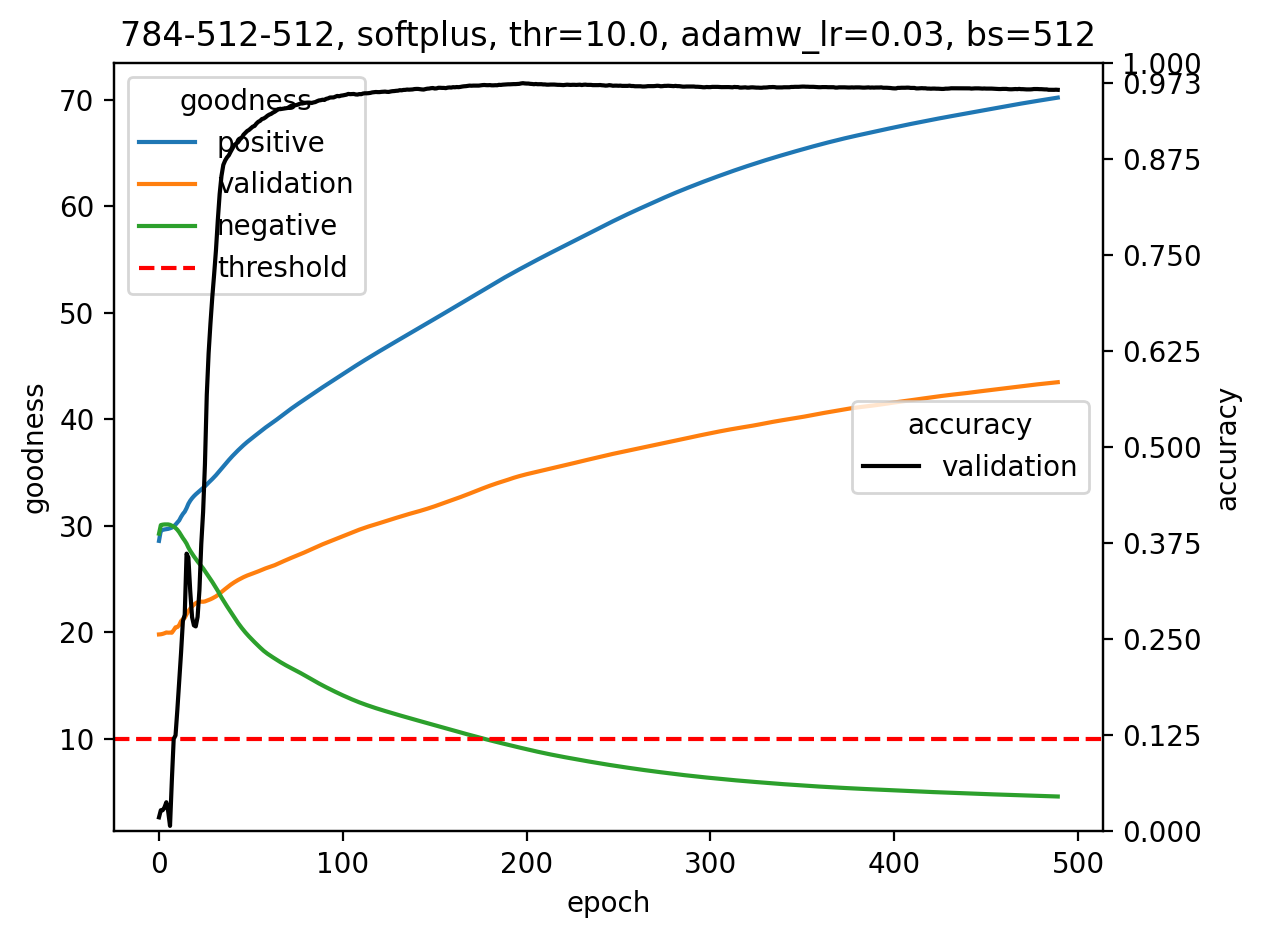

In [179]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('epoch')
ax1.set_ylabel('goodness')
ax1.plot(metrics["pos_goodness"], label='positive')
ax1.plot(metrics["valid_goodness"], label='validation')
ax1.plot(metrics["neg_goodness"], label='negative')
ax1.axhline(THRESHOLD, linestyle='--', label='threshold', color='red')
ax1.tick_params(axis='y')
ax1.legend(title='goodness')

ax2 = ax1.twinx()
ax2.set_ylabel('accuracy')
ax2.plot(metrics["valid_accuracy"], color='black', label='validation')
ax2.tick_params(axis='y')
ax2.legend(title='accuracy', loc='center right')
ax2.set_ylim([0., 1.])
ax2.set_yticks(list(np.linspace(0., 1., 9)) + [max(metrics["valid_accuracy"])])

plt.title(f"784-512-512, softplus, thr={THRESHOLD}, adamw_lr={LEARNING_RATE}, bs={BATCH_SIZE}")

fig.tight_layout()
plt.savefig(f'metrics_784-512-512_softplus_{THRESHOLD}_adamw_{LEARNING_RATE}_{BATCH_SIZE}.png', dpi=300)

In [180]:
test_goodness, test_accuracy = evaluate(trained_model, X_test, y_test, BATCH_SIZE)

metrics["test_goodness"] = [test_goodness.item()]
metrics["test_accuracy"] = [test_accuracy.item()]

test_goodness.item(), test_accuracy.item()

(42.365108489990234, 0.9648323059082031)

In [181]:
metrics["batch_size"] = BATCH_SIZE
metrics["threshold"] = THRESHOLD
metrics["learning_rate"] = LEARNING_RATE
metrics["optimizer"] = "adamw"

In [182]:
import json

with open(f"metrics_784-512-512_softplus_{THRESHOLD}_adamw_{LEARNING_RATE}_{BATCH_SIZE}.json", "w") as f:
    json.dump(metrics, f)

In [183]:
def save_model(filename, metrics, model, opt_states):
    with open(filename, "wb") as f:
        f.write((json.dumps(metrics) + "\n").encode())
        eqx.tree_serialise_leaves(f, model)
        eqx.tree_serialise_leaves(f, opt_states)

save_model(f'checkpoint_784-512-512_softplus_{THRESHOLD}_adamw_{LEARNING_RATE}_{BATCH_SIZE}.eqx',
           metrics, trained_model, trained_opt_states)

In [ ]:
# def load_model(filename):
#     with open(filename, "b") as f:
#         new_metrics = json.loads(f.readling().decode())
#         new_model = None